In [61]:
from typing import Sequence
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [62]:
X = []
y = []
seq_length = 20

### Combine all NonViolence CSV's

In [63]:
nonviolence_dfs = [
    pd.read_csv("/kaggle/input/new-generated-extra-10-batch/nonviolence_landmarks_10_combined.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-20batches-28april/nonviolence_trial_extra_deb_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-20batches-28april/nonviolence_trial_extra_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-20batches-28april/nonviolence_trial_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/final-40-total-dataset/nonviolence_landmarks_20_combined.csv"),
    pd.read_csv("/kaggle/input/pose-final-new-5-dataset/nonviolence_landmarks_5_new.csv"),
    pd.read_csv("/kaggle/input/nonviolence-pose-walking/nonviolence_landmarks_5_nv.csv"),
    pd.read_csv("/kaggle/input/nonviolence-hand-on-face/nonviolence_landmarks_5_nv.csv"),
]
nonviolence_df = pd.concat(nonviolence_dfs, ignore_index=True)

### Combine all Violence CSV's

In [64]:
violence_dfs = [
    pd.read_csv("/kaggle/input/violence-only-new-10/violence_landmarks_10_combined.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-20batches-28april/violence_trial_extra_deb_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-20batches-28april/violence_trial_extra_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/pose-lstm-20batches-28april/violence_trial_landmarks_1500.csv"),
    pd.read_csv("/kaggle/input/final-40-total-dataset/violence_landmarks_20_combined.csv"),
    pd.read_csv("/kaggle/input/pose-final-new-5-dataset/violence_landmarks_5_new.csv"),
]

violence_df = pd.concat(violence_dfs, ignore_index=True)

In [65]:
def normalize_pose_with_visibility(pose_vector):
    pose = pose_vector.reshape((33, 4))
    xyz = pose[:, :3]  # only x, y, z
    visibility = pose[:, 3:]  # shape (32, 1)

    # Use shoulders and hips for torso center & scale
    left_shoulder, right_shoulder = xyz[11], xyz[12]
    left_hip, right_hip = xyz[23], xyz[24]

    mid_shoulder = (left_shoulder + right_shoulder) / 2
    mid_hip = (left_hip + right_hip) / 2
    center = (mid_shoulder + mid_hip) / 2

    torso_length = np.linalg.norm(mid_shoulder - mid_hip)
    if torso_length == 0:
        torso_length = 1e-6

    normalized_xyz = (xyz - center) / torso_length
    normalized_pose = np.concatenate([normalized_xyz, visibility], axis=1) 
    return normalized_pose.flatten()

In [66]:
def normalize_csv_with_visibility_loop(input_df):
    normalized_rows = []

    for i, row in input_df.iterrows():
        pose_vector = row.values.astype(np.float32)  # Convert row to float32 array
        normalized_vector = normalize_pose_with_visibility(pose_vector)  # Normalize the pose
        normalized_rows.append(normalized_vector) 

    normalized_df = pd.DataFrame(normalized_rows)
    return normalized_df

In [67]:
normalized_nonviolence_df = normalize_csv_with_visibility_loop(nonviolence_df)
normalized_violence_df = normalize_csv_with_visibility_loop(violence_df)

### If we want to add Velocity as a training parameter we can use the block below

In [68]:
def add_velocity(df, chunk_size=20):
    """
    Computes velocity only on x, y, z (skips visibility) every 'chunk_size' frames.
    Resets velocity to zero at the start of each chunk.
    """
    all_chunks = []
    num_rows, num_cols = df.shape
    joint_dims = 4  # x, y, z, visibility
    num_joints = num_cols // joint_dims

    # Indices for x, y, z (exclude visibility)
    xyz_indices = [i for i in range(num_cols) if (i % joint_dims) != 3]

    for start in range(0, num_rows, chunk_size):
        end = min(start + chunk_size, num_rows)
        chunk = df.iloc[start:end].copy()

        # Only compute velocity on x, y, z
        xyz_array = chunk.iloc[:, xyz_indices].values
        velocity = np.diff(xyz_array, axis=0)

        # Pad first frame of chunk with zeros
        zero_row = np.zeros((1, xyz_array.shape[1]))
        velocity = np.vstack([zero_row, velocity])

        # Create velocity DataFrame
        velocity_cols = [f"v_{df.columns[i]}" for i in xyz_indices]
        velocity_df = pd.DataFrame(velocity, columns=velocity_cols)

        # Merge original (with visibility) and velocity (only x, y, z)
        combined = pd.concat([chunk.reset_index(drop=True), velocity_df], axis=1)
        all_chunks.append(combined)

    return pd.concat(all_chunks, ignore_index=True)


In [69]:
#normalized_nonviolence_df = add_velocity(nonviolence_df)
#normalized_violence_df = add_velocity(violence_df)

In [70]:
normalized_nonviolence_df.to_csv("nonviolence_combined.csv", index=False)
normalized_violence_df.to_csv("violence_combined.csv", index=False)

In [71]:
normalized_violence_df.shape, normalized_nonviolence_df.shape

((27500, 132), (32000, 132))

In [72]:
normalized_nonviolence_df.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,-0.037549,-0.640439,-1.304664,0.999998,-0.019136,-0.696471,-1.247684,0.999996,-0.004957,-0.696644,...,-0.194592,0.949119,0.322749,1.543946,1.793413,0.983261,-0.309344,1.771491,-0.808027,0.997262
1,0.184291,-0.792064,-0.210946,0.999615,0.167336,-0.848790,-0.132917,0.999348,0.164893,-0.848038,...,-0.353273,0.949243,0.105169,1.980467,0.712060,0.968864,0.308648,2.216435,-0.742290,0.992508
2,0.190604,-0.794557,-0.155726,0.999579,0.176886,-0.852193,-0.073274,0.999260,0.175656,-0.851145,...,-0.528895,0.951026,0.085827,2.083236,0.502984,0.955054,0.360218,2.246776,-1.056043,0.990761
3,0.141277,-0.804748,-0.199885,0.999588,0.131356,-0.857832,-0.120615,0.999252,0.131784,-0.856751,...,-0.772584,0.953720,0.049428,2.073100,0.653812,0.950327,0.344721,2.227920,-1.246916,0.990511
4,0.127835,-0.804688,-0.238563,0.999536,0.118847,-0.865210,-0.160193,0.999120,0.120101,-0.864648,...,-0.620919,0.954471,0.016345,2.059787,0.468037,0.944452,0.317263,2.215869,-1.095127,0.989088


In [73]:
normalized_violence_df.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,0.156511,-0.812582,0.472679,0.999492,0.117220,-0.882859,0.497831,0.999417,0.110025,-0.883800,...,-0.687069,0.951783,0.177542,2.056178,1.011487,0.622822,0.185583,2.144070,-0.999037,0.962472
1,0.171876,-0.789595,-0.216468,0.998851,0.136535,-0.857384,-0.132660,0.998231,0.130105,-0.859132,...,-0.066391,0.953132,0.179604,2.021327,1.329496,0.638863,0.169935,2.113823,-0.541829,0.964148
2,0.185459,-0.814876,-0.230992,0.998952,0.149536,-0.882478,-0.148605,0.998383,0.143228,-0.883972,...,-0.228679,0.953723,0.192326,2.036617,1.311764,0.659050,0.168427,2.164029,-0.638955,0.965654
3,0.167159,-0.856270,-0.249673,0.999056,0.133315,-0.927285,-0.144438,0.998543,0.130243,-0.927957,...,-0.393412,0.952478,0.210638,2.097205,1.221353,0.677695,0.179408,2.227757,-0.753785,0.965195
4,0.121349,-0.859455,-0.396868,0.999149,0.096617,-0.926684,-0.277728,0.998684,0.096751,-0.926608,...,-0.580471,0.948198,0.216764,2.077112,1.199690,0.698496,0.158049,2.210712,-1.181337,0.964688


In [74]:
datasets = normalized_nonviolence_df.values
n_samples = len(datasets)
for i in range(seq_length, n_samples):
    X.append(datasets[i-seq_length:i, :])
    y.append(0)

datasets = normalized_violence_df.values
n_samples = len(datasets)
for i in range(seq_length, n_samples):
    X.append(datasets[i-seq_length:i, :])
    y.append(1)

In [75]:
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(59460, 20, 132) (59460,)


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [78]:
X.shape[1], X.shape[2]

(20, 132)

In [79]:
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.3))
model.add(Dense(units=2, activation="softmax"))  # 2 classes

model.compile(optimizer="adam", metrics=["accuracy"], loss="sparse_categorical_crossentropy")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 20, 100)             │          73,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 20, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 20, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,602 (994.54 KB)

 Trainable params: 254,602 (994.54 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='pose_violence_detection.keras',       
    monitor='val_loss',                   
    save_best_only=True,                  
    save_weights_only=False,              
    mode='min',                           
    verbose=1                             
)

In [82]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = dict(enumerate(class_weights))

In [83]:
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_callback])
                   #class_weight=class_weights_dict)

Epoch 1/100
1336/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8355 - loss: 0.3536
Epoch 1: val_loss improved from inf to 0.09100, saving model to pose_violence_detection.keras
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8356 - loss: 0.3534 - val_accuracy: 0.9682 - val_loss: 0.0910
Epoch 2/100
1337/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9617 - loss: 0.1034
Epoch 2: val_loss improved from 0.09100 to 0.04425, saving model to pose_violence_detection.keras
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.9617 - loss: 0.1034 - val_accuracy: 0.9839 - val_loss: 0.0442
Epoch 3/100
1335/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9796 - loss: 0.0567
Epoch 3: val_loss did not improve from 0.04425
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.9796 - loss: 0.0567 - val_accuracy: 0.9841 - val_loss: 0.0451
Epoch 4/100
1336/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9827 - loss: 0.0486
Epoch 4: val_loss did not improve from

In [84]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

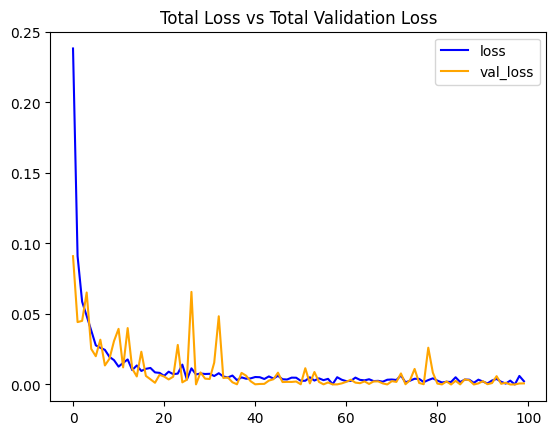

In [85]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

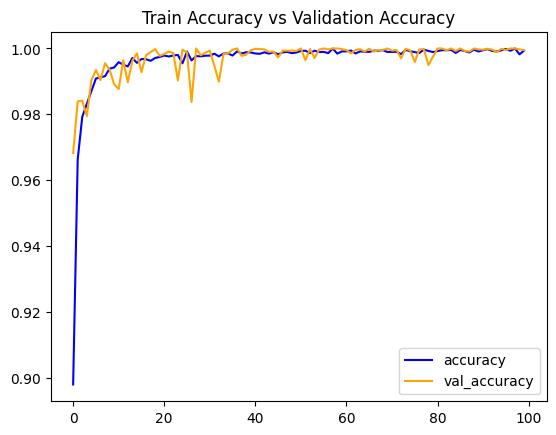

In [86]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Train Accuracy vs Validation Accuracy')

In [87]:
model.save_weights('poseLSTM.weights.h5')

In [88]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 99.95%


In [89]:
preds = model.predict(X_test)
print(preds[:10])

186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
[[9.9999809e-01 1.9320719e-06]
 [9.9999845e-01 1.5919661e-06]
 [9.9999833e-01 1.7220185e-06]
 [9.9999833e-01 1.6500096e-06]
 [1.6664849e-06 9.9999833e-01]
 [2.2968038e-06 9.9999774e-01]
 [1.7835190e-06 9.9999821e-01]
 [1.6637488e-06 9.9999833e-01]
 [1.8213237e-06 9.9999821e-01]
 [4.0435689e-06 9.9999595e-01]]


In [90]:
model.save('poseLSTM.keras')